# Mental Health Screening Checklist

In [27]:
# imports
import re
from itertools import combinations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from matplotlib.gridspec import GridSpec
from matplotlib import rcParams
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import TruncatedSVD
from pyod.models.iforest import IForest

from IPython.display import display_html 

# set font for plots
rcParams['font.family'] = ['Trebuchet MS']

pd.set_option("display.max_rows", None)

In [28]:
# load dataset with observations
df = pd.read_csv("mhsc_data.csv", index_col=0)

In [29]:
# set relevant labels
gender_labels = ["M", "F"]
age_labels = ["17-30", "31-50", "31-50", "51-99", "51-99"]
job_labels = ["Pilot", "Pilot Applicant", "Cabin Crew", "ATC", "Other"]
status_labels = ["Military", "Civilian", "Other"]

# convert bio features to categorical
df["bio_gender"] = pd.cut(df["bio_gender"], bins=[0,1,2], labels=gender_labels, ordered=False)
df["bio_age"] = pd.cut(df["bio_age"], bins=[0,1,2,3,4,5], labels=age_labels, ordered=False)
df["bio_job"] = pd.cut(df["bio_job"], bins=[0,1,2,3,4,5], labels=job_labels, ordered=False)
df["bio_status"] =  pd.cut(df["bio_status"], bins=[0,1,2,3], labels=status_labels, ordered=False)

In [30]:
# limit to pilots, cabin crew and pilot applicants
df = df[df["bio_job"].isin(["Pilot","Cabin Crew", "Pilot Applicant"])]

# 1. GENERAL STATS

## 1.1 BIOGRAPHICAL DATA

In [31]:
# generate table for biographical data
def make_table_bio(df, col):
    col_mapper = {col:(col.split("_")[1]).capitalize(), "count": "Freq", "proportion": "%"}
    freq = df[col].value_counts(normalize=True).to_frame() * 100
    prop = df[col].value_counts().to_frame()
    table = prop.merge(freq, left_index=True, right_index=True)
    return (table
         .reset_index(drop=False)
         .style
            .hide()
            .format(precision=1)
            .format_index(lambda x: col_mapper[x], axis=1)
            .set_table_attributes("style='display:inline;margin-right:48px'")
            .to_html()
)

In [32]:
html=""
for col in df.filter(regex="bio"):
    html += make_table_bio(df, col)
    
display_html(html, raw=True)

Gender,Freq,%
M,124,86.1
F,20,13.9
Age,Freq,%
17-30,67,46.5
31-50,49,34.0
51-99,28,19.4
Job,Freq,%
Pilot,73,50.7
Pilot Applicant,46,31.9
Cabin Crew,25,17.4


## 1.2 ITEM ENDORSMENT RATES

In [33]:
# generate table for mhsc parts
def make_table_mhsc_part(part, job = None):
    data = df
    if job != None:
        data = df[df["bio_job"] == job]
    return (
        (data.filter(regex=part).clip(0,1).sum() / df.shape[0])
        .to_frame()
        .reset_index(drop=False)
        .rename(columns={"index": "Item", 0: "%"})
        .style
            .format(precision=2)
            .hide()
            .background_gradient(cmap="BuGn")
            .set_table_attributes("style='display:inline;margin-right:48px'")
            .to_html()
    )


In [34]:
html=""
for part in ["mhsc_01", "mhsc_02","mhsc_03"]:
    html += make_table_mhsc_part(part)
    html += make_table_mhsc_part(part, "Pilot") 
    html += make_table_mhsc_part(part, "Cabin Crew")
    html += make_table_mhsc_part(part, "Pilot Applicant") + "<br/>"
    
display_html(html, raw=True)

Item,%
mhsc_01_01,0.09
mhsc_01_02,0.09
mhsc_01_03,0.01
mhsc_01_04,0.06
mhsc_01_05,0.01
mhsc_01_06,0.03
mhsc_01_07,0.10
mhsc_01_08,0.10
mhsc_01_09,0.05
mhsc_01_10,0.05


## 1.3 CONTINGENCY TABLES

In [35]:
# generate contingency table
def get_contingency_table(df, regex_pattern, grouping, unstuck_level=None):
    data = df.filter(regex=f"bio|{regex_pattern}").copy()
    def fn(x):
        d = x.filter(regex=regex_pattern)
        d_counts = d.clip(0,1).sum(axis=1).value_counts()
        return d_counts

    grouped_data = data.groupby(grouping).apply(fn)
    if unstuck_level != None:
        grouped_data = grouped_data.unstack(level=unstuck_level, fill_value=0)
    return (pd.concat(
            [
                grouped_data.loc[:, 0],
                pd.Series(grouped_data.loc[:, 1:].sum(axis=1), name="1").astype(int),
            ], axis=1)
            .reset_index(drop=False)
            .style
                .hide()
                .set_table_attributes("style='display:inline;margin-right:48px'")
                .to_html()
        )

In [36]:
html=""
for (df, regex_pattern, grouping, unstuck_level) in [
    (df, "mhsc_03_\d+", ["bio_gender", "bio_age"], -1),
    (df, "mhsc_01_\d+", ["bio_job", "bio_gender",], -1),
    (df, "mhsc_01_\d+", ["bio_job", "bio_age",], -1)
]:
    html += get_contingency_table(df, regex_pattern, grouping, unstuck_level)
    
display_html(html, raw=True)

bio_gender,bio_age,0,1
M,17-30,53,4
M,31-50,36,5
M,51-99,23,3
F,17-30,9,1
F,31-50,7,1
F,51-99,1,1
bio_job,bio_gender,0,1
Pilot,M,55,14
Pilot,F,4,0
Pilot Applicant,M,33,9


## 2. MHSC OUTLIER DETECTION PIPE

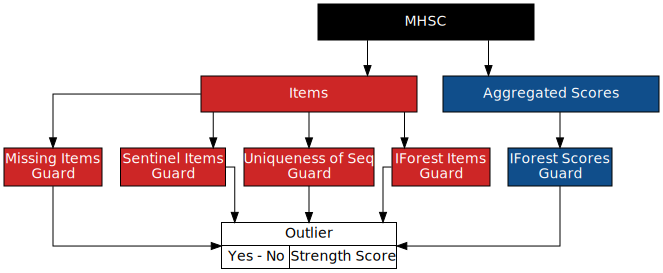

In [37]:
from graphviz import Source
# Create Digraph object
src = '''
digraph G {
  fontname="Trebuchet MS,Helvetica,Arial,sans-serif"
  node [fontname="Trebuchet MS,Helvetica,Arial,sans-serif"]
  edge [fontname="Trebuchet MS,Helvetica,Arial,sans-serif"]
  splines=ortho
  subgraph {
    2 [shape=box, label="MHSC", width=3, style=filled, fillcolor="black", fontcolor="white"]
    3 [shape=box label="Items", width=3, style=filled, fillcolor="firebrick3", fontcolor="white"]
    4 [shape=box label="Aggregated Scores", width=3, style=filled, fillcolor="dodgerblue4", fontcolor="white"]
    5 [shape=box, label="Missing Items\nGuard", style=filled, fillcolor="firebrick3", fontcolor="white"]
    6 [shape=box, label="Sentinel Items\nGuard", style=filled, fillcolor="firebrick3", fontcolor="white"]
    7 [shape=box, label="Uniqueness of Seq\nGuard", style=filled, fillcolor="firebrick3", fontcolor="white"]
    8 [shape=box, label="IForest Items\nGuard", style=filled, fillcolor="firebrick3", fontcolor="white"]
    9 [shape=box, label="IForest Scores\nGuard", style=filled, fillcolor="dodgerblue4", fontcolor="white"]
    10 [shape=record label="{ Outlier |{Yes - No|Strength Score}}" ]
    2 -> {3; 4;}
    3 -> {5;6;7;8}
    4 -> 9
    {5;6;7;8;9;} -> 10;
  }
}
'''
flow = Source(src)
flow.render("./media/flow")
Source(src)

## Pre train relevant steps of pipe

In [38]:
need_retrain = True

# compute aggregated score function
def compute_mhsc_parts(df):
    df["mhsc_part01_tot"] = df.filter(regex="mhsc_01").sum(axis=1)
    df["mhsc_part02_tot"] = df.filter(regex="mhsc_02").sum(axis=1)
    df["mhsc_part03_tot"] = df.filter(regex="mhsc_03").sum(axis=1)
    df["mhsc_part04_tot"] = df.filter(regex="mhsc_04").sum(axis=1)
    return df

# add aggregated score to df
df = compute_mhsc_parts(df)

# retrain relevant steps of pipe
# retraining is need when dataset changes substantially
if need_retrain:
    
    # compute unique sequence of items
    sequences =  df.filter(regex="mhsc_01|mhsc_03").astype(str).sum(axis=1).value_counts()
    recurrent_sequences = (sequences[sequences == 1]).index.to_list()
    
    # isolation forests
    isof_items, isof_parts = IForest(random_state = 42), IForest(random_state = 42)
    df_mhsc_items = df.filter(regex="mhsc_\d")
    df_mhsc_parts = df.filter(regex="mhsc_part")
    isof_items.fit(df_mhsc_items)
    isof_parts.fit(df_mhsc_parts)  

## 2.1 OUTLIER DETECTION PIPE STEPS FUNCTIONS

### 2.1.1 Missingness Guard

In [39]:
def missing_items_guard(df):
    # check whther there are any missing items
    df["outlier_missing"] =\
        df.filter(regex="mhsc").apply(lambda x: np.where(x.isnull().any(), -1, 1), axis=1)
    return df

### 2.1.2 Sentinel Items Guard

In [40]:
def sentinel_items_guard(df):
    def check_conditions(s):
        # self harm or harm to other is positive
        c1 = (s[["mhsc_01_05"]] != 0).any()
        # drug comsumptiom is positive
        c2 = (s[["mhsc_02_04", "mhsc_02_05"]] != 0).any()
        # ongoing psy treatments or problems with law are positives
        c3 = (s[["mhsc_03_01", "mhsc_03_05"]] != 0).any()
        # low perceived well being is positive 
        c4 = s["mhsc_04_01"] < 6
        # compute sentinel outlier label (-1: otulier, 1: non outlier)
        sentinel = -1 if pd.Series([c1,c2,c3,c4]).any() else 1
        return sentinel
    # add sentinel items guard
    df["outlier_sentinel"] = df.apply(check_conditions, axis=1)
    # return df
    return df

### 2.1.3 Uniqueness Guard

In [41]:
def uniqueness_of_sequence_guard(df, recurrent_sequences):
    df["outlier_uniqueness"] = (
        df.filter(regex="mhsc_01|mhsc_03").astype(str).sum(axis=1).isin(recurrent_sequences)
    ).replace({True: -1, False: 1})
    return df

### 2.1.4 Isolation Forests Guards

In [42]:
def isofs_guard(df, isof_items, isof_parts):
    # set constant
    OUTLIER_THRESHOLD = .9
    # filter data to feed isolation forests
    df_mhsc_items = df.filter(regex="mhsc_\d")
    df_mhsc_parts = df.filter(regex="mhsc_part") 
    # set isofs
    isofs = [
        ("isof_items", isof_items, df_mhsc_items, OUTLIER_THRESHOLD), 
        ("isof_parts", isof_parts, df_mhsc_parts, OUTLIER_THRESHOLD),
    ]
    # compute isolation forests scores
    for label, isof, data, threshold in isofs:
        decision_col, outlier_col = f"decision_{label}", f"outlier_{label}"
        df[decision_col] = isof.decision_function(data.values)
        df[outlier_col] = np.where(df[decision_col] >= df[decision_col].quantile(threshold), -1, 1)
    return df

### 2.1.5 Outlier strength

In [43]:
def outlier_strength(df):
    def compute_strength(x):
        score = 0
        # positive sentinel items dersrve high attention
        if x["outlier_sentinel"] == -1: score = .08
        # choose the highest
        score = np.max([((x == -1).sum() / x.shape[0]), score])
        return score
    df["outlier_strength"] = df.filter(regex="outlier").apply(compute_strength, axis=1)
    return df

##  3 APPLY PIPE IN ORDER TO IDENTIFY OUTLIERS

In [44]:
df = (df
        .pipe(missing_items_guard)
        .pipe(sentinel_items_guard)
        .pipe(uniqueness_of_sequence_guard, recurrent_sequences = recurrent_sequences)
        .pipe(isofs_guard, isof_items=isof_items, isof_parts=isof_parts)
        .pipe(outlier_strength)
     )

df.head()

,bio_gender,bio_age,bio_job,bio_status,enac_self_assessment,enac_self_report_atypical,enac_interview_atypical,enac_need_referral,mhsc_01_01,mhsc_01_02,...,mhsc_part03_tot,mhsc_part04_tot,outlier_missing,outlier_sentinel,outlier_uniqueness,decision_isof_items,outlier_isof_items,decision_isof_parts,outlier_isof_parts,outlier_strength
bio_id,,,,,,,,,,,,,,,,,,,,,
1,F,17-30,Cabin Crew,Civilian,7,0,0,0,1,0,...,0,7,1,1,1,-0.060480,1,-0.075265,1,0.0
2,F,17-30,Cabin Crew,Civilian,8,0,0,0,0,0,...,0,8,1,1,1,-0.184474,1,-0.126060,1,0.0
3,M,17-30,Pilot,Civilian,9,0,0,0,0,0,...,0,9,1,1,1,-0.119424,1,-0.025383,1,0.0
4,M,17-30,Pilot Applicant,Civilian,8,1,0,0,0,0,...,1,8,1,1,-1,-0.009103,1,0.010350,-1,0.4
5,M,31-50,Cabin Crew,Civilian,8,0,0,0,0,0,...,0,8,1,1,1,-0.187046,1,-0.178756,1,0.0


# 4. IDENTIFIED OUTLIERS

## 4.1 Outliers Stats

In [45]:
count_of_outiers = df.filter(regex="outlier(?!_strength)").apply(lambda x: (x==-1).any(), axis=1).sum()
perc_of_otuliers = count_of_outiers / df.shape[0]
# show percentages of identified outliers
"total percentage of outliers: {:.1f}%".format(perc_of_otuliers * 100)

'total percentage of outliers: 20.1%'

In [46]:
outliers_columns = [f"outlier_{o}" for o in ["sentinel","uniqueness","isof_items", "isof_parts"]]

outliers_data = (df[outliers_columns]
        .value_counts(normalize=True)
        .to_frame()
        .iloc[1:]
        .reset_index(drop=False))

(outliers_data.groupby(by=
    (outliers_data.iloc[:,:-1] == -1).sum(axis=1).sort_values()).sum().iloc[:,[-1]] 
).style.format(precision=2)

outlier_scores = (
    df.pivot_table(index=outliers_columns, values="bio_gender", aggfunc=np.size).reset_index(drop=False)
)

grouping = pd.Series(
        ["strong outlier","moderate outlier","moderate outlier","weak outlier","moderate outlier",
         "moderate outlier","moderate outlier","weak outlier","weak outlier","weak outlier","no outlier"])

(outlier_scores
    .groupby(grouping)["bio_gender"].sum() / df.shape[0]
).to_frame().reindex(
    ["no outlier", "weak outlier","moderate outlier","strong outlier"]
).rename(columns={"bio_gender": "%"}).round(2)*100

,%
no outlier,80.0
weak outlier,8.0
moderate outlier,10.0
strong outlier,2.0


In [72]:
outliers_columns = [f"outlier_{o}" for o in ["missing", "sentinel","uniqueness","isof_items", "isof_parts"]]

outliers_by_step = (df[(df[outliers_columns] == -1).any(axis=1)][[*outliers_columns]])

(
    outliers_by_step
        .astype(str)
        .value_counts(normalize=True)
        .reset_index(drop=False)
        .round(2)
)

,outlier_missing,outlier_sentinel,outlier_uniqueness,outlier_isof_items,outlier_isof_parts,proportion
0,1,1,-1,-1,-1,0.21
1,1,1,-1,1,1,0.17
2,1,1,-1,-1,1,0.14
3,1,-1,-1,-1,-1,0.10
4,1,-1,1,1,1,0.10
5,1,-1,1,1,-1,0.07
6,1,1,-1,1,-1,0.07
7,1,1,1,1,-1,0.07
8,1,-1,-1,-1,1,0.03
9,1,1,1,-1,1,0.03


### outliers_columns = [f"outlier_{o}" for o in ["sentinel","uniqueness","isof_items", "isof_parts"]]

outlier_scores_by_job = (df.pivot_table(
    index=outliers_columns, columns="bio_job", values="bio_gender", fill_value=0, aggfunc=np.size)
     .reset_index(drop=False)
)

grouping = ["strong outlier","moderate outlier","moderate outlier","weak outlier","moderate outlier",
         "moderate outlier","moderate outlier","weak outlier","weak outlier","weak outlier","no outlier"]

pilot_grouping = [f"pilot {x}" for x in grouping]
applicant_grouping = [f"applicant {x}" for x in grouping]
crew_grouping = [f"crew {x}" for x in grouping]

grouping_combo = pd.Series([*pilot_grouping, *applicant_grouping, *crew_grouping])

(outlier_scores_by_job
     .melt(id_vars=outliers_columns)
     .groupby(grouping_combo)["value"].sum() 
     .to_frame()     
)

## 4.2 Outliers plots

In [48]:
SPLINES_COLOR = "#204571"

In [49]:
# pre process data
X_items = df.filter(regex="mhsc_\d")
X_items = MinMaxScaler().fit_transform(X_items)

X_parts = df.filter(regex="mhsc_part")
X_parts = MinMaxScaler().fit_transform(X_parts)

In [50]:
# init pip steps
min_max = MinMaxScaler()
svd = TruncatedSVD()

# define pipe
pipe = Pipeline(steps=[("min_max", min_max),('svd', svd)])

# add truncated SVD factors
data = pd.concat([
    df.reset_index(drop=False), 
    pd.DataFrame(pipe.fit_transform(df.filter(regex="mhsc_\d")))
], axis=1)

# rename columns
data.columns = [*data.columns[:-2], "svd_f1", "svd_f2"]

# show df
data.head()

,bio_id,bio_gender,bio_age,bio_job,bio_status,enac_self_assessment,enac_self_report_atypical,enac_interview_atypical,enac_need_referral,mhsc_01_01,...,outlier_missing,outlier_sentinel,outlier_uniqueness,decision_isof_items,outlier_isof_items,decision_isof_parts,outlier_isof_parts,outlier_strength,svd_f1,svd_f2
0,1,F,17-30,Cabin Crew,Civilian,7,0,0,0,1,...,1,1,1,-0.060480,1,-0.075265,1,0.0,1.048170,0.427581
1,2,F,17-30,Cabin Crew,Civilian,8,0,0,0,0,...,1,1,1,-0.184474,1,-0.126060,1,0.0,0.442867,-0.227536
2,3,M,17-30,Pilot,Civilian,9,0,0,0,0,...,1,1,1,-0.119424,1,-0.025383,1,0.0,1.386243,-0.076035
3,4,M,17-30,Pilot Applicant,Civilian,8,1,0,0,0,...,1,1,-1,-0.009103,1,0.010350,-1,0.4,0.972169,0.093312
4,5,M,31-50,Cabin Crew,Civilian,8,0,0,0,0,...,1,1,1,-0.187046,1,-0.178756,1,0.0,0.529544,-0.219594


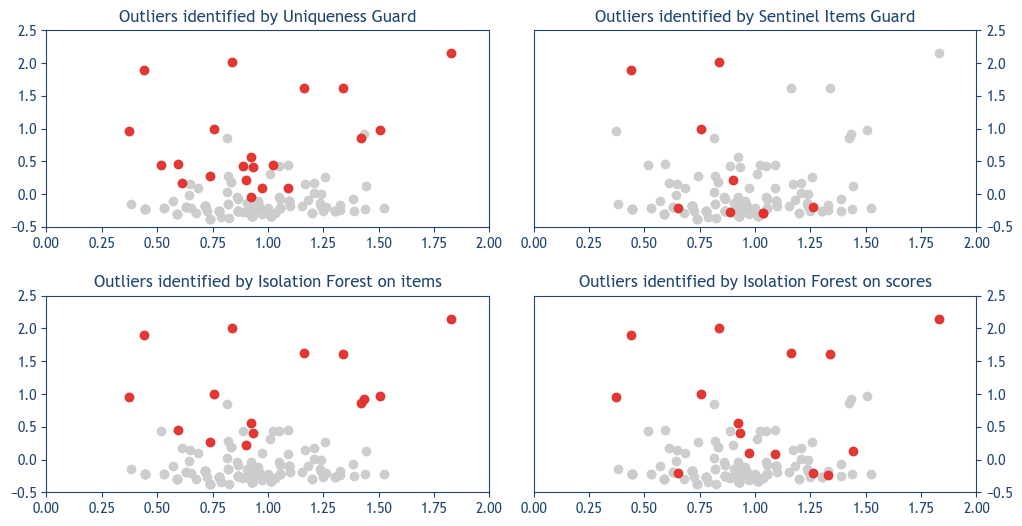

In [51]:
fig = plt.figure(figsize=(12,6))

gs = GridSpec(2, 2, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

alpha=.95

for algo, ax in zip(["uniqueness", "sentinel", "isof_items", "isof_parts"], [ax1, ax2, ax3, ax4]):
    outliers_mask =  data.loc[:, f"outlier_{algo}"] == -1
    ax.scatter(data["svd_f1"], data["svd_f2"], c="#ccc", alpha=alpha)
    ax.scatter(
        data.loc[outliers_mask, "svd_f1"], 
        data.loc[outliers_mask, "svd_f2"], 
        c="#e5302d", 
        alpha=alpha
    )
    
for idx, ax in enumerate([ax1, ax2, ax3, ax4], 1):
    if idx % 2 == 0: ax.yaxis.tick_right() 
    ax.set_xlim(0, 2)
    ax.set_ylim(-.5, 2.5)
    
    ax.tick_params(color=SPLINES_COLOR, labelcolor=SPLINES_COLOR)
    for spine in ax.spines.values():
        spine.set_edgecolor(SPLINES_COLOR)

ax1.set_title("Outliers identified by Uniqueness Guard", c=SPLINES_COLOR)
ax2.set_title("Outliers identified by Sentinel Items Guard", c=SPLINES_COLOR)
ax3.set_title("Outliers identified by Isolation Forest on items", c=SPLINES_COLOR)
ax4.set_title("Outliers identified by Isolation Forest on scores", c=SPLINES_COLOR)
        
plt.subplots_adjust(wspace=0.1, hspace=.35)
plt.savefig("./media/plot1.pdf", bbox_inches='tight')

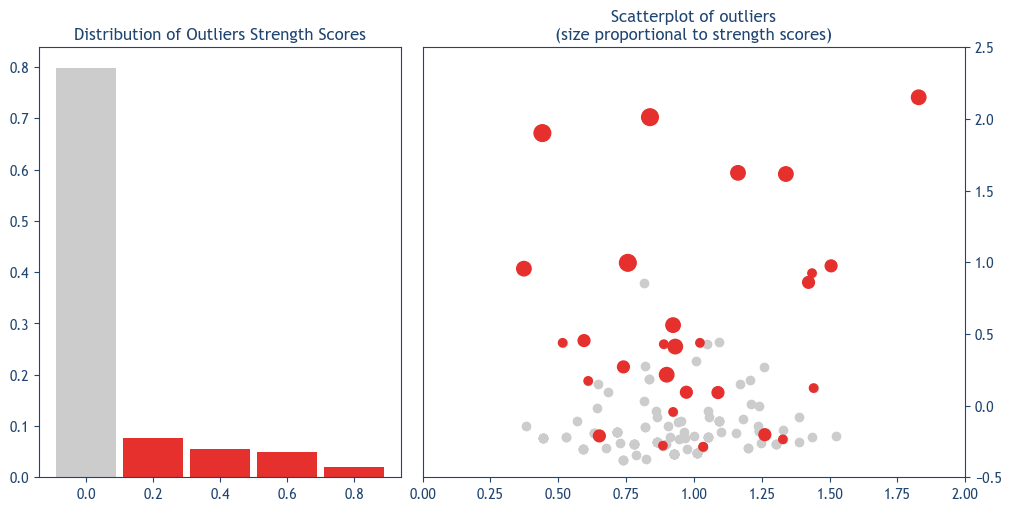

In [52]:
fig = plt.figure(figsize=(10, 5), layout="constrained")

gs = GridSpec(1, 5, figure=fig)

# bar plot
ax1 = fig.add_subplot(gs[0, :2])
ax1_data = data["outlier_strength"].value_counts(normalize=True).sort_index()
(
    ax1_data
        .plot.bar(
         width=.9, 
         color = ["#ccc","#e5302d","#e5302d","#e5302d","#e5302d"],
         ax=ax1
     )
)
ax1.set_xlabel("")
ax1.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation=0)
ax1.set_title(f"Distribution of Outliers Strength Scores", c=SPLINES_COLOR);

# scatter plot
ax2 = fig.add_subplot(gs[0, 2:])
outliers_mask = (data.filter(regex="outlier") == -1).any(axis=1)
ax2.scatter(data["svd_f1"], data["svd_f2"], c="#ccc")
ax2.scatter(
    data.loc[outliers_mask, "svd_f1"], 
    data.loc[outliers_mask, "svd_f2"], 
    s=data.loc[outliers_mask, "outlier_strength"]*180, 
    c="#e5302d"
)
ax2.set_title(f"Scatterplot of outliers\n(size proportional to strength scores)", c=SPLINES_COLOR);
ax2.yaxis.tick_right();
ax2.set_xlim(0,2)
ax2.set_ylim(-.5,2.5);

for idx, ax in enumerate([ax1, ax2], 1):
    ax.tick_params(color=SPLINES_COLOR, labelcolor=SPLINES_COLOR)
    for spine in ax.spines.values():
        spine.set_edgecolor(SPLINES_COLOR)

plt.savefig("./media/plot2.pdf", bbox_inches='tight')